<a href="https://colab.research.google.com/github/valdolab/DS_mAIstros/blob/main/Assigments/Assigment_3_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 3** 
Housing Data Predictions  Linear Regression and KNN

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#import the lbs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy import Nominatim
from scipy.stats import multivariate_normal as mvn
from tqdm import tqdm


## Import clean data

In [225]:
#import new data
data = pd.read_csv('/content/drive/MyDrive/Classroom/DS mAIstros/datasets/new_raw_house_data.csv')
data

,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,kitchen_features,fireplaces,floor_covering,HOA
0,5300000.0,85637,-1.103782,31.356362,2154.00,5272.00,1941,13,10.0,10500.000000,0.0,1435,6.0,263,0.000000
1,4200000.0,85646,-111.045371,31.594213,1707.00,10422.36,1997,2,2.0,7300.000000,0.0,1436,5.0,268,0.000000
2,4200000.0,85646,-111.040707,31.594844,1707.00,10482.00,1997,2,3.0,3716.366828,3.0,1741,5.0,271,82.750698
3,4500000.0,85646,-111.035925,31.645878,636.67,8418.58,1930,7,5.0,9019.000000,4.0,1269,4.0,187,82.750698
4,3411450.0,85750,-110.813768,32.285162,3.21,15393.00,1995,4,6.0,6396.000000,3.0,1754,5.0,71,55.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,495000.0,85641,-110.661829,31.907917,4.98,2017.00,2005,5,3.0,3601.000000,3.0,729,1.0,1,82.750698
4996,550000.0,85750,-110.858556,32.316373,1.42,4822.01,1990,4,3.0,2318.000000,3.0,572,1.0,1,43.000000
4997,475000.0,85192,-110.755428,32.964708,12.06,1000.00,1969,3,2.0,1772.000000,0.0,1375,0.0,164,82.750698
4998,550000.0,85745,-111.055528,32.296871,1.01,5822.93,2009,4,4.0,3724.000000,3.0,1062,1.0,1,82.750698


<Axes: >

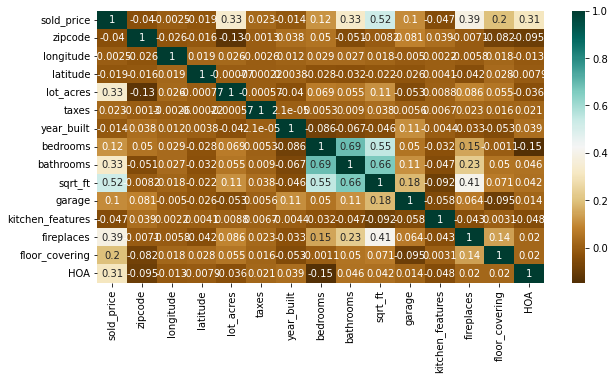

In [5]:
plt.figure(figsize=(10,5))
c = data.corr()
sns.heatmap(c,cmap="BrBG",annot=True)

## Feature engineer

In [ ]:
#trying to get info from latitude and longitude
geolocator = Nominatim(user_agent="mAIstros")
Latitude = "32.296871"
Longitude = "-111.055528"
location = geolocator.reverse(Latitude+","+Longitude)
address = location.raw['address']
print(address)


Latitude = "31.594213"
Longitude = "-111.045371"
location = geolocator.reverse(Latitude+","+Longitude)
address = location.raw['address']
print(address)

In [228]:
#generate new engineer feature 
price_sqrtft = pd.DataFrame(data['sold_price']/data['sqrt_ft'], columns=['price_fts'])
#make a scale categori
min_price_fts = int(min(price_sqrtft['price_fts']))
max_price_fts = int(max(price_sqrtft['price_fts']))
num_class = 5
#automatic scale, but is several imbalanced
scale = list(range(min_price_fts,max_price_fts,int(max_price_fts/(num_class))))
scale.append(max_price_fts+1)
labels = range(1,num_class+1)

#this doesn't work
#so, I created a manual scale
#scale2 = [24, 150]
#scale2 = scale2 + list(range(170,280,int((280-150)/(num_class-1))))
#scale2.append(max_price_fts+1)
#scale2 = [24, 150, 168, 180, 193, 202, 212, 223, 245, 280, 1209]

#create cat feature
price_sqrtft['class_feature_engineer'] = pd.cut(x=price_sqrtft['price_fts'],
                     bins=scale,
                     labels=labels)

#create data to make classification
data_2 = pd.DataFrame(data[['longitude','latitude']])
data_2 = pd.concat([data_2, price_sqrtft['class_feature_engineer']], axis=1)
data_2['class_feature_engineer'].value_counts()
data_2['class_feature_engineer'] = data_2['class_feature_engineer'].astype('int')
data_2
#scale2

,longitude,latitude,class_feature_engineer
0,-1.103782,31.356362,2
1,-111.045371,31.594213,3
2,-111.040707,31.594844,5
3,-111.035925,31.645878,2
4,-110.813768,32.285162,3
...,...,...,...
4995,-110.661829,31.907917,1
4996,-110.858556,32.316373,1
4997,-110.755428,32.964708,2
4998,-111.055528,32.296871,1


In [229]:
#normalize data
for column in data_2.iloc[:,:-1]:
    #data_2[column] = data_2[column]  / data_2[column].abs().max()
    data_2[column] = (data_2[column] - data_2[column].min()) / (data_2[column].max() - data_2[column].min())    
  
data_2

,longitude,latitude,class_feature_engineer
0,1.000000,0.087469,2
1,0.013237,0.088206,3
2,0.013279,0.088208,5
3,0.013322,0.088367,2
4,0.015316,0.090350,3
...,...,...,...
4995,0.016679,0.089180,1
4996,0.014914,0.090447,1
4997,0.015839,0.092458,2
4998,0.013146,0.090386,1


In [230]:
#convert to numpy 
X = data_2.to_numpy()
X

array([[1.        , 0.08746869, 2.        ],
       [0.01323681, 0.08820649, 3.        ],
       [0.01327867, 0.08820845, 5.        ],
       ...,
       [0.01583914, 0.0924577 , 2.        ],
       [0.01314564, 0.0903861 , 1.        ],
       [0.0144244 , 0.08755833, 1.        ]])

## Classification model

### Split dataset to training and test

In [231]:
#first shufle the dataset
np.random.shuffle(X)
num_test = int(len(X)*0.10)

#and the split for training and test, and also the target feature
X_test = X[0:num_test,:-1]
y_test = X[0:num_test,-1].astype(int)
X_train = X[num_test:,:-1]
y_train = X[num_test:,-1].astype(int)

X_train

array([[0.01465148, 0.0903856 ],
       [0.01441098, 0.09039221],
       [0.01547704, 0.09025903],
       ...,
       [0.01516159, 0.0903729 ],
       [0.01392972, 0.09072535],
       [0.01466952, 0.09027215]])

### Implementation of the classifiers

#### kNN classifier

In [57]:
class KNNclassifier():
    def fit(self, X, y):
        self.X = X
        self.y = y
    
    def predict(self, X, K, epsilon=1e-3):
        N = len(X)
        y_hat = np.zeros(N)
        for i in tqdm(range(N)):
            dist2 = np.sum((self.X-X[i])**2, axis=1)
            idxt = np.argsort(dist2)[:K]
            gamme_k = 1/(np.sqrt(dist2[idxt]+epsilon))
            y_hat[i] = np.bincount(self.y[idxt], weights=gamme_k).argmax()
        
        return y_hat

### Testing

In [58]:
#accuracy function
def accuracy(y, y_hat):
    return np.mean(y==y_hat)

In [232]:
#testing using the training dataset as test
knn_model = KNNclassifier()
knn_model.fit(X_train, y_train)
k = 3
y_hat_train = knn_model.predict(X_train, k)
#get accuracy
accuracy(y_hat_train, y_train)

100%|██████████| 4500/4500 [00:01<00:00, 2289.48it/s]


0.9233333333333333

In [233]:
#testing using the test dataset as test
knn_model = KNNclassifier()
knn_model.fit(X_train, y_train)
k = 3
y_hat_test = knn_model.predict(X_test, k)
#get accuracy
accuracy(y_hat_test, y_test)

100%|██████████| 500/500 [00:00<00:00, 2302.46it/s]


0.89

## Feature selection for regression

In [781]:
# features selection and adding the new engineer feature
data_aux = pd.DataFrame(data, columns=['bedrooms','sqrt_ft','sold_price','fireplaces'])
#using the new engineer feature generated
#data_toreg = pd.concat([data_aux, data_2['class_feature_engineer'], data['bathrooms']], axis=1)
#data_toreg
#without the new feature
data_toreg = pd.DataFrame(data, columns=['bedrooms','sqrt_ft','sold_price','fireplaces','bathrooms'])
#data_toreg = pd.DataFrame(data, columns=['sqrt_ft','bathrooms'])
data_toreg

,bedrooms,sqrt_ft,sold_price,fireplaces,bathrooms
0,13,10500.000000,5300000.0,6.0,10.0
1,2,7300.000000,4200000.0,5.0,2.0
2,2,3716.366828,4200000.0,5.0,3.0
3,7,9019.000000,4500000.0,4.0,5.0
4,4,6396.000000,3411450.0,5.0,6.0
...,...,...,...,...,...
4995,5,3601.000000,495000.0,1.0,3.0
4996,4,2318.000000,550000.0,1.0,3.0
4997,3,1772.000000,475000.0,0.0,2.0
4998,4,3724.000000,550000.0,1.0,4.0


In [782]:
#normalizate data
#normalize data
for column in data_toreg.iloc[:,:-1]:
    #normalization
    #data_toreg[column] = data_toreg[column]  / data_toreg[column].abs().max()
    #data_toreg[column] = (data_toreg[column] - data_toreg[column].min()) / (data_toreg[column].max() - data_toreg[column].min())    
    #standarization
    data_toreg[column] = (data_toreg[column]-data_toreg[column].mean())/data_toreg[column].std()
data_toreg

,bedrooms,sqrt_ft,sold_price,fireplaces,bathrooms
0,7.279969,6.087313e+00,14.205915,3.627809,10.0
1,-1.552801,3.215784e+00,10.752829,2.747102,2.0
2,-1.552801,8.161377e-16,10.752829,2.747102,3.0
3,2.462094,4.758333e+00,11.694579,1.866395,5.0
4,0.053157,2.404577e+00,8.277437,2.747102,6.0
...,...,...,...,...,...
4995,0.856136,-1.035248e-01,-0.877794,-0.775727,3.0
4996,0.053157,-1.254829e+00,-0.705140,-0.775727,3.0
4997,-0.749822,-1.744783e+00,-0.940577,-1.656434,2.0
4998,0.053157,6.849649e-03,-0.705140,-0.775727,4.0


<Axes: >

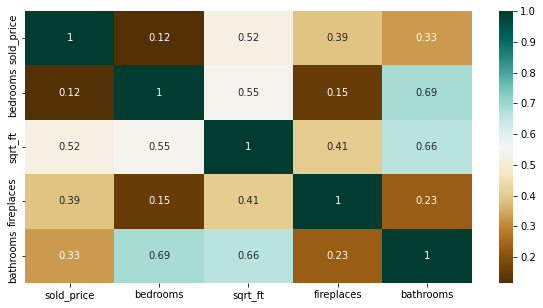

In [362]:
#seems like this new feature generated will not help to the regression prediction
plt.figure(figsize=(10,5))
c = data_toreg.corr()
sns.heatmap(c,cmap="BrBG",annot=True)

In [783]:
#convert to numpy array
X_reg = data_toreg.to_numpy()
#split target feature
y_reg = X_reg[:,-1]
y_reg.shape

(5000,)

In [784]:
X_reg = X_reg[:,:-1]
X_reg.shape

(5000, 4)

## Regression model


### Linear regression

In [241]:
class LinearRegression():
    def fit(self, X, y):
        self.w = np.linalg.solve(X.T@X, X.T@y)
    
    def predict(self, X):
        return np.matmul(X, self.w)

In [772]:
def OLS(Y,Y_hat,N):
    return (1/(2*N)*np.sum((Y-Y_hat)**2))
def R2(Y,Y_hat):
    return (1-(np.sum((Y-Y_hat)**2)/np.sum((Y-np.mean(Y))**2)))

In [243]:
class MVLinearRegression():
    
    def fit(self, X,y, eta = 1e-3, epochs =1e3, show_curve = False):
        epochs =int(epochs)
        N, D = X.shape
        Y =y

        #Initialize the weights
        self.W =np.random.randn(D)
    
        J = np.zeros(epochs)

        for epoch in range(epochs):
            Y_hat = self.predict(X)
            J[epoch] = OLS(Y, Y_hat, N)
            #weight update Rule:
            self.W -= eta*(1/N)*(X.T@(Y_hat-Y))

        if show_curve:
            plt.figure()
            plt.plot(J)
            plt.xlabel("epochs")
            plt.ylabel("$\mathcal{J}$")
            plt.title("Training Curve")
            plt.show()

    def predict(self,X):
        return X @ self.W

In [336]:
class OURLinearRegression():
    
    def fit(self, X, y, eta = 1e-3, epochs = 1e3, show_curve = False, lambd = 0, p = 1):
        epochs = int(epochs)
        N, D = X.shape
        Y = y
        
        self.W = np.random.randn(D)
        
        J = np.zeros(epochs)
        
        for epoch in range(epochs):
            Y_hat = self.predict(X)
            J[epoch] = OLS(Y, Y_hat, N) + (lambd/(p*N))*np.linalg.norm(self.W, ord=p, keepdims=True)
            #print((lambd/(p*N))*np.linalg.norm(self.W, ord=p, keepdims=True))
            self.W -= eta*(1/N)*(X.T@(Y_hat - Y) + (1/N)*(lambd*np.abs(self.W)**(p-1)*np.sign(self.W)))
                    
        #print("This is W:", self.W)
        #print("This is J:", J)
        #print("This is P_hat:", P_hat)    
        if show_curve:
            plt.figure()
            plt.plot(J)
            plt.xlabel("epochs")
            plt.ylabel("$\mathcal{J}$")
            plt.title("Training Curve")
            plt.show()        
    def predict(self, X):
        return X @ self.W

In [435]:
class KNNRegressor():
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def predict(self, X, K, epsilon=1e-3):
        N = len(X)
        y_hat = np.zeros(N)
        
        for i in range(N):
            dist2 = np.sum((self.X - X[i])**2, axis=1)
            idxt = np.argsort(dist2)[:K]
            gamma_k = np.exp(-dist2[idxt])/np.exp(-dist2[idxt]).sum()
            y_hat[i] = gamma_k.dot(self.y[idxt])
        
        return y_hat

In [461]:
knnr = KNNRegressor()
knnr.fit(X_reg,y_reg)

In [462]:
y_hat = knnr.predict(X_reg, 5)
y_hat2 = knnr.predict(X_reg, 40)

#### Plot using numbers of bathrooms and sqrt_ft

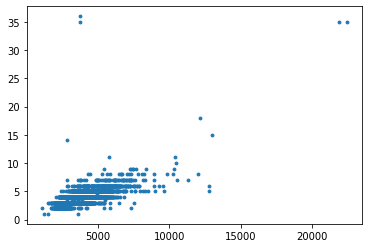

In [457]:
#plot
plt.figure()
plt.scatter(X_reg, y_reg, s=8)
#plt.plot(X_reg, y_hat, color="#ff0070")
#plt.plot(X_reg, y_hat2, color="#00ff00")

### Make predictions

In [785]:
#import the toy dataset
myReg = MVLinearRegression()

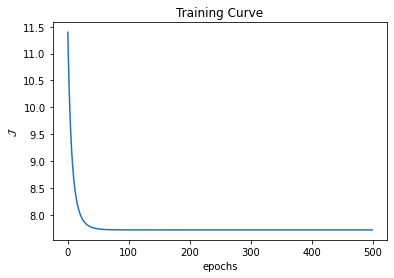

In [786]:
myReg.fit(X_reg,y_reg, epochs=5e2, eta=0.05, show_curve=True)

In [792]:
#test with one example
Xtest = np.array([[2.462094,	4.758333e+00, 11.694579,	1.866395]])
myReg.predict(Xtest)

array([5.45250421])

In [377]:
myReg2 = OURLinearRegression()

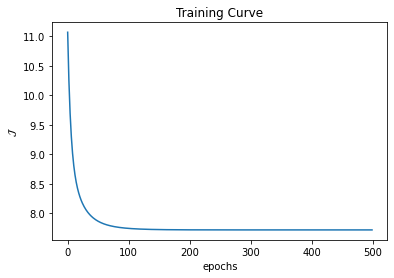

In [795]:
myReg2.fit(X_reg,y_reg, epochs=5e2, eta=0.05, show_curve=True)